##### Esboço para a analise



Utilizando modelo de black scholes e calculando a vol implicita de mercado minimizando a MQO ponderada temos

A idéia então é minimizar o erro quadrático médio do mercado e encontrar essas duas váriaveis

c:\Users\diogo\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Under,Strike,Venc,Tipo,Preço,Volume,Black-Scholes
0,AAAA3,25,365,Call,77.022029,260800,77.827714
1,AAAA3,26,365,Call,77.556945,274000,76.940793
2,AAAA3,27,365,Call,77.339647,282500,76.053873
3,AAAA3,28,365,Call,74.264279,297700,75.166952
4,AAAA3,29,365,Call,75.016137,302400,74.280032
...,...,...,...,...,...,...,...
145,AAAA3,170,365,Call,0.589886,298500,0.003286
146,AAAA3,171,365,Call,2.364003,292400,0.002787
147,AAAA3,172,365,Call,0.120545,281300,0.002361
148,AAAA3,173,365,Call,1.111372,282300,0.001999


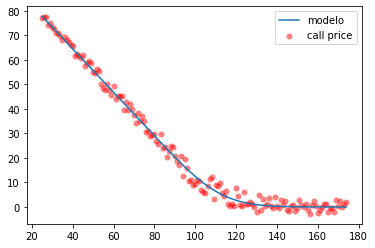

In [115]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import sys
import warnings
import yfinance as yf
from scipy import stats
import risk_functions as rf
from scipy.optimize import minimize
import black_scholes as bs

### abrrir o arquivo  options.csv

opcs = pd.read_csv('opcs.csv', encoding='ANSI')



teste = opcs.sample(150)

X = teste['Strike'].values
Y = teste['Preço'].values
weight = teste['Volume'].values / teste['Volume'].sum()


price = 100
r = 0.12
maturity = 1



def error(params):
    sigma, add_price = params
    call_modelo = bs.bs_call(price+add_price,teste['Strike'].values, maturity, r, sigma)
    mqo = (Y - call_modelo)**2
    mqo = (mqo * weight).mean()

    return mqo

targuet = [.9,0.0]

resultado = minimize(error, targuet, method='Nelder-Mead')
sigma, add_price = resultado.x

## Teste

X = opcs['Strike'].values
Y = opcs['Preço'].values

call_modelo = bs.bs_call(price+add_price, X, maturity, r, sigma)

plt.plot(X, call_modelo, label='modelo')
sns.scatterplot(X, Y, label='call price', linewidth=0, alpha=0.5, color='red')

opcs['Black-Scholes'] = call_modelo

opcs 


In [118]:
opcs 

,Under,Strike,Venc,Tipo,Preço,Volume,Black-Scholes,Weight
0,AAAA3,25,365,Call,77.022029,260800,77.827714,0.000950
1,AAAA3,26,365,Call,77.556945,274000,76.940793,-0.000759
2,AAAA3,27,365,Call,77.339647,282500,76.053873,-0.000215
3,AAAA3,28,365,Call,74.264279,297700,75.166952,0.000164
4,AAAA3,29,365,Call,75.016137,302400,74.280032,-0.020289
...,...,...,...,...,...,...,...,...
145,AAAA3,170,365,Call,0.589886,298500,0.003286,-0.000032
146,AAAA3,171,365,Call,2.364003,292400,0.002787,-0.003433
147,AAAA3,172,365,Call,0.120545,281300,0.002361,-0.001959
148,AAAA3,173,365,Call,1.111372,282300,0.001999,-0.002583


In [119]:
opcs['Weight']

0      0.000950
1     -0.000759
2     -0.000215
3      0.000164
4     -0.020289
         ...   
145   -0.000032
146   -0.003433
147   -0.001959
148   -0.002583
149   -0.001753
Name: Weight, Length: 150, dtype: float64

-23.083994096569846

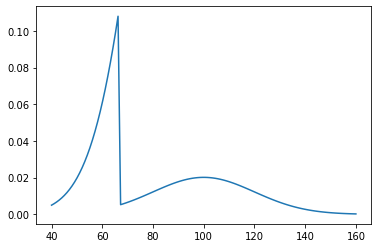

In [227]:
# Payoff no vencimento

opcs['Weight'] = np.random.random(len(opcs))**2 
opcs['Weight'] = opcs['Weight'] / opcs['Weight'].sum()
opcs['Weight'] = opcs['Weight'] * (1-2*(opcs['Preço'] > opcs['Black-Scholes']))




# Defining o simulador

def simulador(weights):

    weights = weights / weights.sum()

    spots = np.linspace(40, 160, 120)

    matriz_payoff = pd.DataFrame(spots, columns=['Spot'])

    for i, spot_i in enumerate(spots):
        px_carteira = spot_i - opcs['Strike'] 
        px_carteira[px_carteira < 0] = 0
        px_carteira = ((px_carteira - opcs['Preço']) * weights).sum()
        matriz_payoff.loc[i, 'Payoff'] = px_carteira

    matriz_payoff.sort_values('Payoff', inplace=True)

    matriz_payoff['Probability'] = stats.norm.pdf(matriz_payoff['Spot'], 100,20)
    matriz_payoff['Probability'] = matriz_payoff['Probability'] / matriz_payoff['Probability'].sum()

    # score
    matriz_payoff['Importancia'] = matriz_payoff['Probability'].cumsum() 
    matriz_payoff['Importancia'] = (matriz_payoff['Importancia'] < 0.05) #5% piores dias
    matriz_payoff['Importancia'] = matriz_payoff['Importancia'] * matriz_payoff['Probability'] # Peso 
    matriz_payoff['Importancia'] = matriz_payoff['Importancia'] / matriz_payoff['Importancia'].sum()

    plt.plot(matriz_payoff['Spot'], matriz_payoff['Importancia'])

    score = (matriz_payoff['Importancia'] * matriz_payoff['Payoff']).sum()  # (Expected shortfall)
    score += (matriz_payoff['Probability'] * matriz_payoff['Payoff']).sum()  # (Expected return)
     
    # Porque o score é Cvar + Expected Return ? 
    # Como Volatilidade não faz sentido, já que estamos olhando para o vencimento das opções
    # Como as outras métricas com CVaR;VaR;Stress Correlate podem possuir valores negativos ou positivos ( Caso alguma simulação considere grandes desvios de Vol Implicita)
    # Como expected return pode ser positivo ou negativo; Uma razão entre essas váriaveis não faz sentido
    # A melhor opção que sobra é a soma do CVaR que explora todos os piores dias, e o retorno médio que explora todos os dias

    return score

simulador(np.ones(len(opcs)))